In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from bounds import *
from dgp import *
from vset import *
import estimation, utils, experiments, vset, plots


# Debugging IV identification

In [2]:
def compute_iv_bounds(dgp, data, nuisance_probs):
    
    XU, Z, T = data['XU'], data['Z'], data['T']
    N, Dx, Du = dgp['N'], dgp['Dx'], dgp['Du']

    p_mu1 = nuisance_probs['p_mu1']
    p_e1 = nuisance_probs['p_e1']
    p_mu1_z = nuisance_probs['p_mu1_z']
    p_e1_z = nuisance_probs['p_e1_z']

    mu_down_z = np.zeros((dgp['nz'], dgp['N']))
    mu_up_z = np.zeros((dgp['nz'], dgp['N']))
    
    # Compute upper and lower bounds on mu(a,x)
    for z in range(dgp['nz']):
        e0_z = 1-p_e1_z[z]
        mu_down_z[z] = p_e1_z[z] * p_mu1_z[z]
        mu_up_z[z] = e0_z + p_e1_z[z] * p_mu1_z[z]

    mu_down = mu_down_z.max(axis=0)
    mu_up = mu_up_z.min(axis=0)
    
    v110_up = (T * (mu_up - p_mu1 * p_e1)).mean()
    v100_up = ((1-T) * (mu_up - p_mu1 * p_e1)).mean()

    v110_down = (T * (mu_down - p_mu1 * p_e1)).mean()
    v100_down = ((1-T) * (mu_down - p_mu1 * p_e1)).mean()
    
    Vpf_down = np.zeros((2,2))
    Vpf_up = np.zeros((2,2))
    
    Vpf_down[0,1], Vpf_down[1,1] = v110_down, v110_down
    Vpf_down[0,0], Vpf_down[1,0] = v100_down, v100_down
    Vpf_up[0,1], Vpf_up[1,1] = v110_up, v110_up
    Vpf_up[0,0], Vpf_up[1,0] = v100_up, v100_up

    return Vpf_down, Vpf_up

def compute_nuisance_probs(dgp, data, setting):
    
    XU, D, Y, Z  = data['XU'], data['D'], data['Y'], data['Z']
    
    # We don't have access to confounders when computing bounds.
    mu1_coeffs = dgp['mu1_coeffs'].copy()
    e1_coeffs = dgp['e1_coeffs'].copy()
    mu1_coeffs[Dx:] = 0
    e1_coeffs[Dx:] = 0

    if setting=='oracle':
        p_mu1 = mu(dgp, mu1_coeffs, XU, Z)
        p_e1 = e1(dgp, e1_coeffs, XU, Z)
        
        p_mu1_z = mu_down_z = np.zeros((dgp['nz'], dgp['N']))
        p_e1_z = mu_down_z = np.zeros((dgp['nz'], dgp['N']))
        
        for z in range(dgp['nz']):
            p_mu1_z[z] = mu(dgp, mu1_coeffs, XU, z)
            p_e1_z[z] = e1(dgp, e1_coeffs, XU, z)
            
            
    return {
        'p_mu1': p_mu1,
        'p_e1': p_e1,
        'p_mu1_z': p_mu1_z,
        'p_e1_z': p_e1_z
    }

def check_bounds(data, Vpf_down, Vpf_up):
    '''Given observational data (Y,D,T) ~ p() compute bounds across measures of interest.'''

    Y, D, T = data['Y'], data['D'], data['T']
    v = np.zeros((2,2,2))

    for y in range(2):
        for d in range(2):
            for t in range(2):
                v[y,t,d] = ((Y==y) & (D==d) & (T==t)).mean()

    metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1', 'm_u']
    u = np.array([[1,0], [0, 1]])

    for metric in metrics:

        R_oracle = oracle_regret(v, u, metric)
        Rs_down, Rs_up = standard_bounds(v, Vpf_down, Vpf_up, u, metric)
        Rd_down, Rd_up = delta_bounds(v, Vpf_down, Vpf_up, u, metric)

        print(f'metric: {metric}')
        print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
        print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
        print(f'Oracle: {R_oracle:.4}')
        print()

        
lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)
Nsims = 10

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}


dgp = set_dgp_config(dgp, 'IV')
data  = generate_data(dgp.copy())
nuisance_probs = compute_nuisance_probs(dgp.copy(), data.copy(), setting='oracle')
Vpf_down, Vpf_up = compute_iv_bounds(dgp.copy(), data.copy(), nuisance_probs)
check_bounds(data.copy(), Vpf_down, Vpf_up)


metric: m_y=1
Standard bounds [-0.473, -0.367]
Delta bounds: [-0.453, -0.387]
Oracle: -0.4258

metric: m_y=0
Standard bounds [-0.481, -0.376]
Delta bounds: [-0.462, -0.395]
Oracle: -0.4246

metric: m_a=0
Standard bounds [-0.118, 0.118]
Delta bounds: [-0.0751, 0.0758]
Oracle: -0.00716

metric: m_a=1
Standard bounds [-0.0147, 0.0283]
Delta bounds: [-0.0147, 0.0283]
Oracle: 0.002592

metric: m_u
Standard bounds [-0.036, 0.0494]
Delta bounds: [-0.00851, 0.0219]
Oracle: 0.005



In [3]:
dgp = set_dgp_config(dgp.copy(), 'IV')
data = generate_data(dgp.copy())    

# probs = compute_nuisance_probs(dgp.copy(), data.copy(), setting='oracle')

# Vpf_down, Vpf_up = compute_iv_bounds(dgp.copy(), data.copy(), nuisance_probs)
# check_bounds(data.copy(), Vpf_down, Vpf_up)

# When I use estimation.oracle_nuisance_probs() to compute probs, then things break
probs = estimation.oracle_nuisance_probs(dgp.copy(), data.copy())
Vpf_down, Vpf_up = vset.get_vset(dgp.copy(), data.copy(), probs, 'IV')
check_bounds(data.copy(), Vpf_down, Vpf_up)

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([-1.56343957,  1.93116437, -0.18700465,  0.49507509, -0.78340276,
       -0.14297674,  1.34146352]), 'z_coeffs': array([ 1.85306828,  1.62698103, -1.11115326,  1.78376748, -1.44697125,
        0.        ,  0.        ]), 'mu1_coeffs': array([ 0.05997317,  1.26178434,  0.32786777,  1.31226602, -0.55485549,
       -0.71320047,  1.89191743]), 'mu0_coeffs': array([-1.19150293,  1.18363265,  0.23603551,  0.64216251,  0.47043508,
        1.72464538, -1.56750208]), 'lambda': 1.5, 'lambda_star': 1.7, 'id_assumption': 'IV', 'beta_zd': 2}
metric: m_y=1
Standard bounds [-0.485, -0.38]
Delta bounds: [-0.466, -0.4]
Oracle: -0.4411

metric: m_y=0
Standard bounds [-0.485, -0.376]
Delta bounds: [-0.465, -0.396]
Oracle: -0.4153

metric: m_a=0
Standard bounds [-0.117, 0.119]
Delta bounds: [-0.0738, 0.0765]
Oracle: -0.03041

metric: m_a=1
Standard bounds [-0.0184, 0.0244]
Delta bounds: [-0.0184, 0.0244]
Oracle: -0.007562


In [2]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 2
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)


## Test learning outcome probabilities

In [3]:
msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='oracle', K=5)

,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.442321,0.205203,-0.299383,0.046694,1,1,-0.044788,m_y=1,MSM,oracle
1,-0.453623,0.184842,-0.314613,0.024438,1,1,-0.303794,m_y=0,MSM,oracle
2,-0.621289,0.505295,-0.244548,0.128554,1,1,0.122409,m_a=0,MSM,oracle
3,-0.110657,0.269244,-0.110657,0.269244,1,1,0.124838,m_a=1,MSM,oracle
4,-0.367146,0.388546,-0.122113,0.143513,1,1,0.092100,m_u,MSM,oracle


In [84]:
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)

outcome regression error: 0.043218950581498154
propensitiy error: 0.026068173306555392
outcome regression error: 0.03883126286322675
propensitiy error: 0.025846728054586564
outcome regression error: 0.04162230822009172
propensitiy error: 0.024802039095536528
outcome regression error: 0.039635756080474094
propensitiy error: 0.02578407892389513
outcome regression error: 0.03992138284299188
propensitiy error: 0.025476313405033636


,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.545193,-0.338356,-0.508254,-0.377225,1.0,1.0,-0.449353,m_y=1,MSM,plugin
1,-0.550948,-0.342820,-0.514499,-0.381328,1.0,1.0,-0.458090,m_y=0,MSM,plugin
2,-0.280651,0.218070,-0.195899,0.133319,1.0,1.0,0.001760,m_a=0,MSM,plugin
3,-0.027843,0.057846,-0.027843,0.057846,1.0,1.0,0.007186,m_a=1,MSM,plugin
4,-0.084671,0.085471,-0.028803,0.029603,1.0,1.0,0.002100,m_u,MSM,plugin


# Coverage sample size experiment 
- Construct 95% bootstrap CI around plug-in estimates of the regret. Plot as a function of sample size.
- Also plot coverage as a function of sample size.

In [57]:
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5
}

msm_dgp = set_dgp_config(dgp, 'MSM')
Ns = [100, 300, 600, 900, 1200, 1500, msm_dgp['N']-1]
coveragedf = experiments.estimation_coverage_experiment(msm_dgp, Ns, Nsims=30)



outcome regression error: 0.162007979903376
propensitiy error: 0.12829266069716455
outcome regression error: 0.21428660193377227
propensitiy error: 0.12536641381719696
outcome regression error: 0.13328763835731078
propensitiy error: 0.17966554742024948
outcome regression error: 0.18146031808097557
propensitiy error: 0.12841599665850859
outcome regression error: 0.24541782300738832
propensitiy error: 0.1647079261615631
oracle dgp {'N': 100, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regressi

outcome regression error: 0.21569601880973727
propensitiy error: 0.11084696018333184
outcome regression error: 0.18584138266480893
propensitiy error: 0.14808786770287047
outcome regression error: 0.2534049229999121
propensitiy error: 0.1635588863951482
outcome regression error: 0.18970391886223806
propensitiy error: 0.2038823615910494
outcome regression error: 0.16870631753586776
propensitiy error: 0.1405911436944452
oracle dgp {'N': 100, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regressio

outcome regression error: 0.1115064609998651
propensitiy error: 0.11290725388188476
outcome regression error: 0.13321284862314745
propensitiy error: 0.0995192509472309
oracle dgp {'N': 100, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.16628365806577272
propensitiy error: 0.12820148528824762
outcome regression error: 0.4222416589743604
propensitiy error: 0.14885349750812935
outcome regression error: 0.14425854230761764
propensitiy error: 0.11287269007975105
outcome regressi

outcome regression error: 0.14893226183612612
propensitiy error: 0.13965243453927653
oracle dgp {'N': 100, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.2304648768726522
propensitiy error: 0.08079901159803043
outcome regression error: 0.24204696909783358
propensitiy error: 0.09063428256445294
outcome regression error: 0.1915592849929309
propensitiy error: 0.1219677592960668
outcome regression error: 0.20407625826701592
propensitiy error: 0.12121137026081101
outcome regressi

oracle dgp {'N': 300, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.0756195080053646
propensitiy error: 0.07240153791704816
outcome regression error: 0.10726746020164768
propensitiy error: 0.0849114880073752
outcome regression error: 0.08579528118522224
propensitiy error: 0.09009357032226045
outcome regression error: 0.09788004045022673
propensitiy error: 0.06317877558496687
outcome regression error: 0.08202469745080208
propensitiy error: 0.0805009025109079
oracle dgp {'N':

outcome regression error: 0.10846248106873925
propensitiy error: 0.07335103573808953
outcome regression error: 0.10320394929551843
propensitiy error: 0.09226414769156634
outcome regression error: 0.11891752245241931
propensitiy error: 0.07643005075760116
outcome regression error: 0.1071191570800246
propensitiy error: 0.0909889375087027
oracle dgp {'N': 300, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.10514099099410566
propensitiy error: 0.11241185146339479
outcome regress

outcome regression error: 0.058101230095512386
propensitiy error: 0.09569179490731607
outcome regression error: 0.0716732814789077
propensitiy error: 0.07963494379353293
outcome regression error: 0.046729309243140275
propensitiy error: 0.07519904294045068
oracle dgp {'N': 300, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.10546072653611539
propensitiy error: 0.08609673680262758
outcome regression error: 0.08435180227554498
propensitiy error: 0.07127221319879463
outcome regr

outcome regression error: 0.048349791833053365
propensitiy error: 0.07613645471116394
outcome regression error: 0.06018808331091926
propensitiy error: 0.0806828046223537
outcome regression error: 0.05208309780988513
propensitiy error: 0.0713979589360255
outcome regression error: 0.05475412964442914
propensitiy error: 0.06268483525517785
outcome regression error: 0.07857792683131064
propensitiy error: 0.06181047826256026
oracle dgp {'N': 600, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regres

outcome regression error: 0.08234085403789851
propensitiy error: 0.056436831454634344
outcome regression error: 0.07402578521090805
propensitiy error: 0.06652461760656724
outcome regression error: 0.05314254264885068
propensitiy error: 0.07035218952594685
oracle dgp {'N': 600, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.06374271071972562
propensitiy error: 0.0671341518220087
outcome regression error: 0.06538828372837155
propensitiy error: 0.08608989621168218
outcome regre

outcome regression error: 0.043123320094054535
propensitiy error: 0.07585057928749293
outcome regression error: 0.07943627897496942
propensitiy error: 0.0820966304486305
outcome regression error: 0.04321144143892566
propensitiy error: 0.07345169647283194
outcome regression error: 0.05859712007850447
propensitiy error: 0.08550525921649799
outcome regression error: 0.06356146562248488
propensitiy error: 0.06756766498983238
oracle dgp {'N': 600, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regre

oracle dgp {'N': 900, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.04394338272370171
propensitiy error: 0.07822400823246552
outcome regression error: 0.0478895299301572
propensitiy error: 0.07980024991616738
outcome regression error: 0.044486555461048904
propensitiy error: 0.069697885500776
outcome regression error: 0.02558194574535731
propensitiy error: 0.07071701008377883
outcome regression error: 0.050777441027191866
propensitiy error: 0.06972693349628607
oracle dgp {'N

outcome regression error: 0.04802226238562329
propensitiy error: 0.06922771458118242
outcome regression error: 0.0614520392794544
propensitiy error: 0.07858180728320091
outcome regression error: 0.04576043618888919
propensitiy error: 0.06508495337462998
oracle dgp {'N': 900, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.0546637927525232
propensitiy error: 0.06963651515934709
outcome regression error: 0.0551866332742309
propensitiy error: 0.06810107431688081
outcome regressi

outcome regression error: 0.05070502108767307
propensitiy error: 0.0815620413825532
outcome regression error: 0.04351514537064162
propensitiy error: 0.07222683410019154
oracle dgp {'N': 900, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.03930263236825842
propensitiy error: 0.07177516025612143
outcome regression error: 0.03871428696425811
propensitiy error: 0.07719843151794756
outcome regression error: 0.06779999056894212
propensitiy error: 0.07384077859704515
outcome regres

outcome regression error: 0.03506612886040679
propensitiy error: 0.07518782505771368
outcome regression error: 0.043998184208920384
propensitiy error: 0.0723222541493939
outcome regression error: 0.04985246551410271
propensitiy error: 0.06819063852038167
outcome regression error: 0.048622348445942924
propensitiy error: 0.06393479084972112
outcome regression error: 0.07269946115444006
propensitiy error: 0.06911727302313594
oracle dgp {'N': 1200, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome reg

outcome regression error: 0.040310633659440924
propensitiy error: 0.07488466791807737
outcome regression error: 0.02953676692545074
propensitiy error: 0.07913759672671583
outcome regression error: 0.04214579347117468
propensitiy error: 0.07677464143688824
oracle dgp {'N': 1200, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.049341315056411914
propensitiy error: 0.0640739753879048
outcome regression error: 0.03594699539839314
propensitiy error: 0.07155384753764607
outcome reg

outcome regression error: 0.029706577718848142
propensitiy error: 0.06547903953926835
outcome regression error: 0.047868373081245336
propensitiy error: 0.06835670437399093
outcome regression error: 0.040410919691824664
propensitiy error: 0.06673468843911742
outcome regression error: 0.0454734642460075
propensitiy error: 0.06088810691602483
outcome regression error: 0.0570735565083763
propensitiy error: 0.06878315057555658
oracle dgp {'N': 1200, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome reg

outcome regression error: 0.0468230469365874
propensitiy error: 0.07898274884992672
outcome regression error: 0.04074597730702407
propensitiy error: 0.07056895591751548
oracle dgp {'N': 1500, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.06092049007520486
propensitiy error: 0.0731453234026909
outcome regression error: 0.05938192404830834
propensitiy error: 0.06646000972774449
outcome regression error: 0.05163829578726659
propensitiy error: 0.06727788396771525
outcome regres

outcome regression error: 0.05949391399480594
propensitiy error: 0.06944216912031566
oracle dgp {'N': 1500, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.03096848709645722
propensitiy error: 0.0652184984749818
outcome regression error: 0.027876323448228647
propensitiy error: 0.06915193390664642
outcome regression error: 0.03333444726016778
propensitiy error: 0.07026794714858953
outcome regression error: 0.029747131675800537
propensitiy error: 0.07141016924940527
outcome reg

outcome regression error: 0.04884504666143505
propensitiy error: 0.0626482971486914
outcome regression error: 0.03559909658295988
propensitiy error: 0.06415251857564848
outcome regression error: 0.043096230189196824
propensitiy error: 0.07064489153614398
oracle dgp {'N': 1500, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.0457595547819503
propensitiy error: 0.07228186504967349
outcome regression error: 0.0379063846315129
propensitiy error: 0.06490066617768833
outcome regres

oracle dgp {'N': 9999, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.02773872384977472
propensitiy error: 0.062410497641065266
outcome regression error: 0.026448003169346826
propensitiy error: 0.0642747491472776
outcome regression error: 0.029094759289519104
propensitiy error: 0.06260171179405356
outcome regression error: 0.02581967997798919
propensitiy error: 0.06376815619986402
outcome regression error: 0.027512214546550496
propensitiy error: 0.06354003918166294
oracle dg

outcome regression error: 0.02749598552727329
propensitiy error: 0.06381507531157359
outcome regression error: 0.02804432928759008
propensitiy error: 0.06470610447421561
outcome regression error: 0.027888001842898393
propensitiy error: 0.06242622687162364
oracle dgp {'N': 9999, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.028517962869363412
propensitiy error: 0.06321990455179594
outcome regression error: 0.02795583704904441
propensitiy error: 0.06525527326233446
outcome re

outcome regression error: 0.027356300929144737
propensitiy error: 0.06432903359464118
outcome regression error: 0.026200236174847794
propensitiy error: 0.06190357641322996
outcome regression error: 0.029318652328858316
propensitiy error: 0.06447108297790555
outcome regression error: 0.026681454469480743
propensitiy error: 0.06377234566556203
oracle dgp {'N': 9999, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 1.92672456,  1.70140689,  1.43296671, -1.81806376, -0.49763949,
       -0.94307484,  1.71865484]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([ 0.29789799,  2.16013226,  1.70893918, -0.95664198,  2.95592207,
        0.54640276,  0.47225698]), 'mu0_coeffs': array([-0.38418912,  1.93081878,  0.29948736, -0.76821033,  0.65046658,
       -0.78616164, -0.14096331]), 'lambda': 1.5, 'id_assumption': 'MSM', 'lambda_star': 1.021363815710885, 'beta_zd': 0}
outcome regression error: 0.028990648968237727
propensitiy error: 0.06348462366495965
outcome

Text(0, 0.5, 'Accuracy regret')

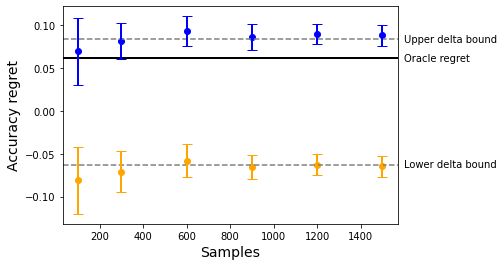

In [10]:
ns_data = experiments.get_est_exp_metadata(coveragedf, Ns)
ns_data = ns_data[ns_data['metric'] == 'm_u']

oracle_up = ns_data['Rd_up_oracle'].tolist()[-1]
oracle_down = ns_data['Rd_down_oracle'].tolist()[-1]
oracle = ns_data['R_oracle'].tolist()[-1]
ns_data = ns_data.iloc[:-1,:]

plt.axhline(oracle_up, color='grey', linestyle='--')
plt.axhline(oracle_down, color='grey', linestyle='--')
plt.axhline(oracle, color='k', linewidth=2,label='$R^*$')

plt.scatter(ns_data['N'], ns_data['Rd_up_pl_mean'], color='blue')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_up_pl_mean'].tolist()[ix], yerr=ns_data['Rd_up_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='blue')

plt.scatter(ns_data['N'], ns_data['Rd_down_pl_mean'], color='orange')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_down_pl_mean'].tolist()[ix], yerr=ns_data['Rd_down_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='orange')
    
# Determine the X location for the text boxes (adjust as needed)
x_loc = max(ns_data['N']) + 100  # Adjust the offset (10 here) as needed

# Add text boxes
plt.text(x_loc, oracle_up, 'Upper delta bound', va='center')
plt.text(x_loc, oracle_down, r'Lower delta bound', va='center', clip_on=False)
plt.text(x_loc, oracle, 'Oracle regret', va='center')

plt.xlabel('Samples', fontsize=14)
plt.ylabel('Accuracy regret', fontsize=14)

Text(0, 0.5, 'Coverage (%)')

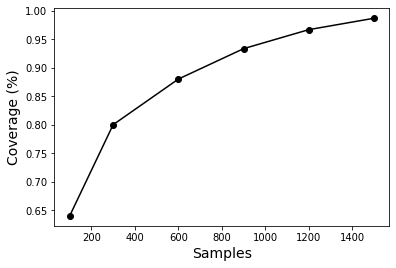

In [11]:
samples = coveragedf[(coveragedf['est_method'] == 'plugin') & (coveragedf['metric'] == 'm_u')]
coverage = samples.groupby('N').mean()['Rd_coverage'].tolist()[:-1]
N = samples.groupby('N').mean().reset_index()['N'].tolist()[:-1]

plt.plot(N, coverage, marker='o', color='k')
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Coverage (%)', fontsize=14)

## Design sensitivity experiment 
- Delta bounds enable certifying a policy improvement up to a larger magnitude of confounding

In [2]:
lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': lambda_star
}

msm_dgp = set_dgp_config(dgp, 'MSM')


In [3]:
lambda_bounds = []
Nsims=10

for lam in lambdas:
    for sim in range(Nsims):

        msm_dgp['lambda'] = lam
        bounds = estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)
        bounds['lambda'] = lam
        lambda_bounds.append(bounds)


NameError: name 'data' is not defined

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_28317/2621745880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf['Rs_includes_zero'] = ((bdf['Rs_down'] <= 0) & (bdf['Rs_up'] >= 0)).astype(int)
/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_28317/2621745880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf['Rd_includes_zero'] = ((bdf['Rd_down'] <= 0) & (bdf['Rd_up'] >= 0)).astype(int)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


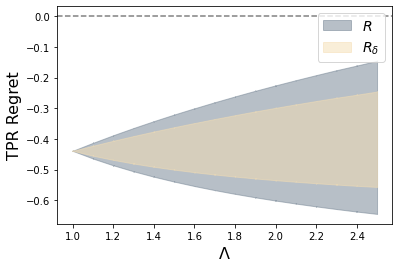

In [14]:
bounddf = pd.concat(lambda_bounds)

bdf = bounddf[bounddf['metric'] == 'm_y=1']


bdf['Rs_includes_zero'] = ((bdf['Rs_down'] <= 0) & (bdf['Rs_up'] >= 0)).astype(int)
bdf['Rd_includes_zero'] = ((bdf['Rd_down'] <= 0) & (bdf['Rd_up'] >= 0)).astype(int)
TS_lambda_star = bdf[bdf['Rs_includes_zero'] == 1]['lambda'].min()
OS_lambda_star = bdf[bdf['Rd_includes_zero'] == 1]['lambda'].min()



plt.fill_between(bdf['lambda'], bdf['Rs_down'],  bdf['Rs_up'], label='$R$', color='#708090', alpha=.5, )
plt.fill_between(bdf['lambda'], bdf['Rd_down'],  bdf['Rd_up'], label='$R_{\delta}$', color='#F5DEB3', alpha=.5,)

regret_intercept = bdf['Rs_down'].tolist()[0]


plt.axvline(TS_lambda_star, color='grey', zorder=1, linestyle='--')
plt.axvline(OS_lambda_star, color='grey', zorder=1, linestyle='--')

plt.axhline(0, color='grey', zorder=1, linestyle='--')

plt.text(TS_lambda_star+.05, -.55, '$\Lambda^*_{R}$', fontsize=14)
plt.text(OS_lambda_star+.05, -.55, '$\Lambda^*_{R_\delta}$', fontsize=14)


plt.xlabel('$\Lambda$', fontsize=16)
plt.ylabel('TPR Regret', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

## Robustness check: violation of exclusion restriction

outcome regression error: 0.07618642758045491
propensitiy error: 0.026008871680045332
outcome regression error: 0.07423388109371702
propensitiy error: 0.025271707301676487
outcome regression error: 0.07312675617997436
propensitiy error: 0.024336347987798924
outcome regression error: 0.07534108638981851
propensitiy error: 0.025495007027869943
outcome regression error: 0.07756565555177433
propensitiy error: 0.02637034986098714
outcome regression error: 0.07595003474142496
propensitiy error: 0.025169451706484637
outcome regression error: 0.07402017682199832
propensitiy error: 0.02493227461762656
outcome regression error: 0.07446864440219834
propensitiy error: 0.02504467113570488
outcome regression error: 0.07570359023864405
propensitiy error: 0.026062637165230277
outcome regression error: 0.07602534267144022
propensitiy error: 0.026120321892603663
outcome regression error: 0.07567915964878302
propensitiy error: 0.023868152991859272
outcome regression error: 0.07458516334235153
propensitiy

outcome regression error: 0.07589690619158622
propensitiy error: 0.025872062409921553
outcome regression error: 0.07377300201079776
propensitiy error: 0.02514554960825528
outcome regression error: 0.0745855356645416
propensitiy error: 0.025494492987075866
outcome regression error: 0.07375838887294804
propensitiy error: 0.026389220233511673
outcome regression error: 0.07593035189401422
propensitiy error: 0.02675546047777065
outcome regression error: 0.07514833012155861
propensitiy error: 0.025913725235633712
outcome regression error: 0.07308010588254717
propensitiy error: 0.0256317274561179
outcome regression error: 0.0747514202760071
propensitiy error: 0.02639320606911009
outcome regression error: 0.07348871994937786
propensitiy error: 0.025065029685423342
outcome regression error: 0.07507371915378605
propensitiy error: 0.02730315796767687
outcome regression error: 0.0750665734760068
propensitiy error: 0.025800862050446592
outcome regression error: 0.07478312341673811
propensitiy error

outcome regression error: 0.07499350459026269
propensitiy error: 0.02486528455915437
outcome regression error: 0.07454667502947875
propensitiy error: 0.02557791156726803
outcome regression error: 0.07478062836023058
propensitiy error: 0.0253219913689241
outcome regression error: 0.07612895544385422
propensitiy error: 0.02580738906965462
outcome regression error: 0.07510404516737856
propensitiy error: 0.026145589388187437
outcome regression error: 0.07425111138218829
propensitiy error: 0.02500782851646477
outcome regression error: 0.0748499716314553
propensitiy error: 0.02638597875391011
outcome regression error: 0.07412968896688964
propensitiy error: 0.025902811664356335
outcome regression error: 0.07543152523917593
propensitiy error: 0.026122090199946175
outcome regression error: 0.07625835608566314
propensitiy error: 0.026014806368483655
outcome regression error: 0.0756227176984689
propensitiy error: 0.025526109460523323
outcome regression error: 0.07471619770206014
propensitiy error

outcome regression error: 0.0755581965450447
propensitiy error: 0.025682990823898032
outcome regression error: 0.07472850665160646
propensitiy error: 0.025492380760167497
outcome regression error: 0.07565384634075743
propensitiy error: 0.025469733024375305
outcome regression error: 0.0766699129519651
propensitiy error: 0.025838360372851768
outcome regression error: 0.07681725335411761
propensitiy error: 0.026174737099175702
outcome regression error: 0.07620224427366079
propensitiy error: 0.024446867033663763
outcome regression error: 0.07494822415950676
propensitiy error: 0.025481231942362438
outcome regression error: 0.07498419327816963
propensitiy error: 0.025324665618672297
outcome regression error: 0.07536241710412654
propensitiy error: 0.025952240177325628
outcome regression error: 0.07415943960049434
propensitiy error: 0.025210634528040857
outcome regression error: 0.07605295069120493
propensitiy error: 0.02563946520535528
outcome regression error: 0.0747773419193617
propensitiy 

outcome regression error: 0.07430147732634253
propensitiy error: 0.02543731989785139
outcome regression error: 0.07525548492748871
propensitiy error: 0.02692746955201048
outcome regression error: 0.07371258597502492
propensitiy error: 0.025743192476530112
outcome regression error: 0.07255987692877389
propensitiy error: 0.025238107379934423
outcome regression error: 0.07283856791490999
propensitiy error: 0.0251559647469404
outcome regression error: 0.07535909174553201
propensitiy error: 0.026452108095054015
outcome regression error: 0.07346363440941424
propensitiy error: 0.024797837973411736
outcome regression error: 0.07487004196747118
propensitiy error: 0.025484399622780016
outcome regression error: 0.07525862601486263
propensitiy error: 0.02656228784800862
outcome regression error: 0.07695365203968405
propensitiy error: 0.026996279634806584
outcome regression error: 0.07466039339769304
propensitiy error: 0.024780397459038973
outcome regression error: 0.07317809292125552
propensitiy e

outcome regression error: 0.07395396452754298
propensitiy error: 0.025629127132031738
outcome regression error: 0.07625079420240545
propensitiy error: 0.027976726540159095
outcome regression error: 0.075655105608931
propensitiy error: 0.026575780009515212
outcome regression error: 0.07464631896801459
propensitiy error: 0.025107608619960593
outcome regression error: 0.07423007201655991
propensitiy error: 0.02641363047264576
outcome regression error: 0.0728717720813996
propensitiy error: 0.02616355400974639
outcome regression error: 0.07466666954917414
propensitiy error: 0.026156662910082198
outcome regression error: 0.07300184849104474
propensitiy error: 0.025707020492895714
outcome regression error: 0.07329357335724188
propensitiy error: 0.02573544056897258
outcome regression error: 0.07338086080802293
propensitiy error: 0.025415026565977147
outcome regression error: 0.07437269491981448
propensitiy error: 0.02624007329325634
outcome regression error: 0.07371655773007035
propensitiy err

outcome regression error: 0.07426488994805781
propensitiy error: 0.025258674831836494
outcome regression error: 0.07410557933800442
propensitiy error: 0.0253694183937998
outcome regression error: 0.07332712543853946
propensitiy error: 0.025921662335088868
outcome regression error: 0.07580930013043076
propensitiy error: 0.027003161516841536
outcome regression error: 0.07518613563513242
propensitiy error: 0.025708476923436252
outcome regression error: 0.07389907333194203
propensitiy error: 0.025058681927351025
outcome regression error: 0.07450748603975701
propensitiy error: 0.024926132929557247
outcome regression error: 0.07484218031233533
propensitiy error: 0.025662604353110373
outcome regression error: 0.07411912285670846
propensitiy error: 0.024786325093461684
outcome regression error: 0.07379253121217011
propensitiy error: 0.025471414501325774
outcome regression error: 0.07392021369978534
propensitiy error: 0.0254697884122883
outcome regression error: 0.0750256077319505
propensitiy e

outcome regression error: 0.07679826093521498
propensitiy error: 0.027228585685076846
outcome regression error: 0.07426439763684713
propensitiy error: 0.026721833291851942
outcome regression error: 0.07413792646375512
propensitiy error: 0.025515257941156833
outcome regression error: 0.07417545629104887
propensitiy error: 0.026419789230377303
outcome regression error: 0.07510420688611882
propensitiy error: 0.026658093712066188
outcome regression error: 0.07372458956475415
propensitiy error: 0.024895120428876354
outcome regression error: 0.07261877703969544
propensitiy error: 0.024162495159455028
outcome regression error: 0.07235287264711715
propensitiy error: 0.02384771400262985
outcome regression error: 0.07259571407318514
propensitiy error: 0.02355068785506727
outcome regression error: 0.0733721223089373
propensitiy error: 0.02421175587679936
outcome regression error: 0.07430003994684355
propensitiy error: 0.025953135923391036
outcome regression error: 0.07274440881035295
propensitiy 

outcome regression error: 0.0735256620729107
propensitiy error: 0.025482223269384076
outcome regression error: 0.07318483344994757
propensitiy error: 0.025709191506995605
outcome regression error: 0.07182762543736262
propensitiy error: 0.02476921760037494
outcome regression error: 0.0735599117439756
propensitiy error: 0.025574628721504043
outcome regression error: 0.07406377504191528
propensitiy error: 0.026131319511447502
outcome regression error: 0.07221186895678679
propensitiy error: 0.024898218661532894
outcome regression error: 0.07392388785607738
propensitiy error: 0.02504727244617584
outcome regression error: 0.07179364032386082
propensitiy error: 0.024913520309407546
outcome regression error: 0.07291830131795399
propensitiy error: 0.02482539776967291
outcome regression error: 0.07317951510301009
propensitiy error: 0.024971647544865028
outcome regression error: 0.07384976416715411
propensitiy error: 0.02571531118208834
outcome regression error: 0.07409925815205938
propensitiy er

outcome regression error: 0.0740688791174893
propensitiy error: 0.025263558465307756
outcome regression error: 0.07234900772983857
propensitiy error: 0.025798864925121342
outcome regression error: 0.07308008087677267
propensitiy error: 0.025881868609429783
outcome regression error: 0.07309672972094151
propensitiy error: 0.025990998717710875
outcome regression error: 0.0734525652698578
propensitiy error: 0.02633468095125023
outcome regression error: 0.0733239466598732
propensitiy error: 0.025997863580271497
outcome regression error: 0.07211610321785747
propensitiy error: 0.025356001828159246
outcome regression error: 0.07127972117225663
propensitiy error: 0.02503705591141298
outcome regression error: 0.0708195037516786
propensitiy error: 0.025026892723135696
outcome regression error: 0.07326758794854517
propensitiy error: 0.025705499903697856
outcome regression error: 0.07242590412784035
propensitiy error: 0.024865159363038163
outcome regression error: 0.07223310030464743
propensitiy er

outcome regression error: 0.07163548851799655
propensitiy error: 0.025353338670060087
outcome regression error: 0.07124092766905196
propensitiy error: 0.02559565799498321
outcome regression error: 0.07196372168779032
propensitiy error: 0.025252801756775575
outcome regression error: 0.07282052285433437
propensitiy error: 0.025219817904994172
outcome regression error: 0.07512074411770796
propensitiy error: 0.02669492779943735
outcome regression error: 0.0733564246389131
propensitiy error: 0.026386092035415195
outcome regression error: 0.07417890541883908
propensitiy error: 0.026483015347941383
outcome regression error: 0.07467477972113835
propensitiy error: 0.026974524053002248
outcome regression error: 0.07346602144038088
propensitiy error: 0.025857630453784662


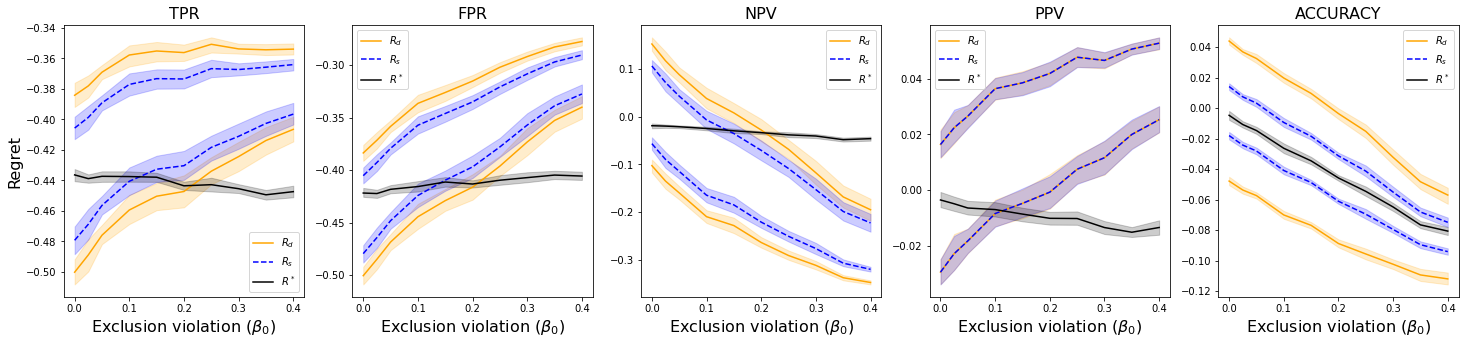

In [6]:
lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)
Nsims = 10

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 20000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

dgp = set_dgp_config(dgp, 'IV')
beta_zy = [0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
bedf = experiments.exclusion_sensitivity_experiment(dgp, beta_zy, n_sims=20, est_method='plugin', K=5)
plots.plot_exclusion_sensitivity(bedf)

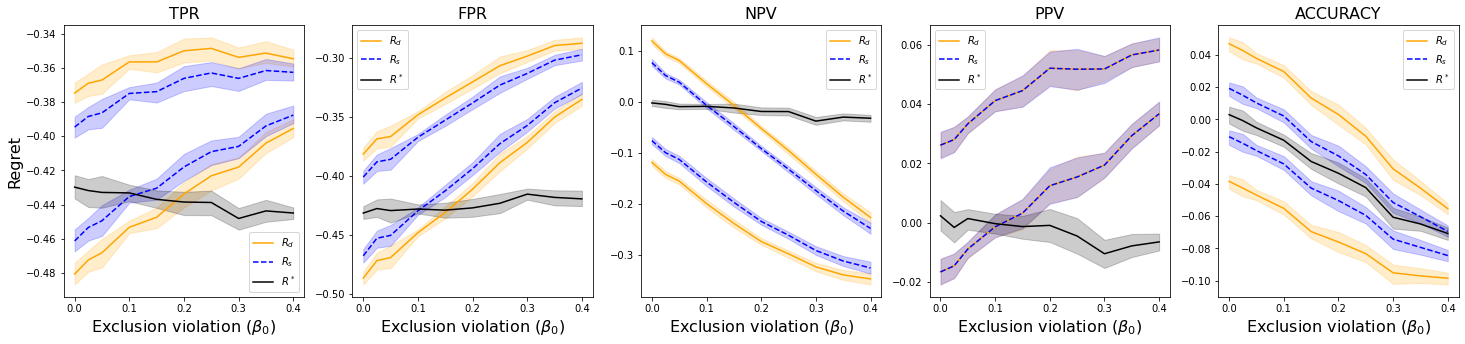

In [4]:
exclusion_bounds = []

for zy in beta_zy:
    iv_dgp['beta_zy'] = zy
    
    for sim in range(Nsims):
        data = generate_data(iv_dgp)    
        bounds = estimation.estimate_bounds(iv_dgp, data, id_method='IV', est_method='oracle', K=5)
        bounds['beta_zy'] = zy
        exclusion_bounds.append(bounds)

bedf = pd.concat(exclusion_bounds)



## Robustness check: violation of relevance 

outcome regression error: 0.10007108148929081
propensitiy error: 0.0637646628754961
outcome regression error: 0.10128595863245872
propensitiy error: 0.066823989078117
outcome regression error: 0.10322982691787261
propensitiy error: 0.06851342908173297
outcome regression error: 0.09853863562460605
propensitiy error: 0.06399183653883433
outcome regression error: 0.10063754595594576
propensitiy error: 0.0656917103049983
outcome regression error: 0.0988133584313754
propensitiy error: 0.06630768768635183
outcome regression error: 0.10298519132026612
propensitiy error: 0.06812135870023664
outcome regression error: 0.09780110666551559
propensitiy error: 0.0665441941034784
outcome regression error: 0.09498475074630355
propensitiy error: 0.06570416602064834
outcome regression error: 0.09632684740493172
propensitiy error: 0.06604291298448087
outcome regression error: 0.09958540493333136
propensitiy error: 0.0672733162233753
outcome regression error: 0.09612658318249108
propensitiy error: 0.06462

outcome regression error: 0.1002093115690633
propensitiy error: 0.0652737578592696
outcome regression error: 0.10009198241102396
propensitiy error: 0.06361971738769673
outcome regression error: 0.10058819184306524
propensitiy error: 0.0632482777544667
outcome regression error: 0.09787455271638268
propensitiy error: 0.06183138227561879
outcome regression error: 0.09975694006475365
propensitiy error: 0.0649716613606071
outcome regression error: 0.09715030977766279
propensitiy error: 0.06337946304418601
outcome regression error: 0.09846108925832743
propensitiy error: 0.0639521966637399
outcome regression error: 0.0975008491393967
propensitiy error: 0.06268128465130014
outcome regression error: 0.0979455384540022
propensitiy error: 0.062411406213009224
outcome regression error: 0.09677013788087199
propensitiy error: 0.06355022875254845
outcome regression error: 0.09501796664784991
propensitiy error: 0.06114070766329384
outcome regression error: 0.09824796309090779
propensitiy error: 0.0636

outcome regression error: 0.09947169791101289
propensitiy error: 0.06138875838640146
outcome regression error: 0.09988437679241184
propensitiy error: 0.06143134075764681
outcome regression error: 0.10011198497181843
propensitiy error: 0.06218423369836248
outcome regression error: 0.09820359131954273
propensitiy error: 0.060582922019933025
outcome regression error: 0.09731280658324391
propensitiy error: 0.05934692249643874
outcome regression error: 0.10059836577776037
propensitiy error: 0.06080667598876392
outcome regression error: 0.10025670159027053
propensitiy error: 0.061639194548615495
outcome regression error: 0.10075328660905913
propensitiy error: 0.06053309773941568
outcome regression error: 0.09926991935012014
propensitiy error: 0.06020504857905773
outcome regression error: 0.10050969663379615
propensitiy error: 0.06369273626208174
outcome regression error: 0.09965577293826021
propensitiy error: 0.05982345964255664
outcome regression error: 0.09603508651579165
propensitiy error

outcome regression error: 0.09713639208352398
propensitiy error: 0.0563275701750238
outcome regression error: 0.0977219078308996
propensitiy error: 0.05270986265654726
outcome regression error: 0.10043833327305823
propensitiy error: 0.054686305574835004
outcome regression error: 0.09543895243662996
propensitiy error: 0.05169426131993681
outcome regression error: 0.09752346511652916
propensitiy error: 0.05302666742324351
outcome regression error: 0.09702762537305006
propensitiy error: 0.05174154597751668
outcome regression error: 0.09883349924502076
propensitiy error: 0.053697575681144874
outcome regression error: 0.10026738530039336
propensitiy error: 0.05427881197289044
outcome regression error: 0.09891950417899927
propensitiy error: 0.054276427853204766
outcome regression error: 0.09971796567467532
propensitiy error: 0.05377831260300961
outcome regression error: 0.09624200602012715
propensitiy error: 0.05340968726319024
outcome regression error: 0.09531369630029005
propensitiy error:

outcome regression error: 0.09737334835795218
propensitiy error: 0.046285064193557886
outcome regression error: 0.09993434750539174
propensitiy error: 0.04768610618332794
outcome regression error: 0.09718251977226583
propensitiy error: 0.04761672667514682
outcome regression error: 0.09620318251191566
propensitiy error: 0.04702507478977946
outcome regression error: 0.09735423243724271
propensitiy error: 0.045470272859856206
outcome regression error: 0.09903860998460223
propensitiy error: 0.047611139339285166
outcome regression error: 0.0988819843595212
propensitiy error: 0.04676406752073308
outcome regression error: 0.09759983703255319
propensitiy error: 0.04615257724548151
outcome regression error: 0.09946787145912028
propensitiy error: 0.04742761798942326
outcome regression error: 0.09525183088748315
propensitiy error: 0.04448734859646751
outcome regression error: 0.0986685415137101
propensitiy error: 0.044929028417863316
outcome regression error: 0.09675362519092041
propensitiy error

outcome regression error: 0.09945279413564702
propensitiy error: 0.04315426978555239
outcome regression error: 0.10140086524979523
propensitiy error: 0.04260176362912465
outcome regression error: 0.10044291804076469
propensitiy error: 0.04027097530144747
outcome regression error: 0.09827519812918789
propensitiy error: 0.0403139754868907
outcome regression error: 0.10387293199916113
propensitiy error: 0.042880895347508066
outcome regression error: 0.09853345007806949
propensitiy error: 0.04051571904440947
outcome regression error: 0.10033514412330152
propensitiy error: 0.04216267143052016
outcome regression error: 0.09872776097213781
propensitiy error: 0.04011310669702829
outcome regression error: 0.10105429424062663
propensitiy error: 0.04108058671591897
outcome regression error: 0.09968549013955796
propensitiy error: 0.042674332162234235
outcome regression error: 0.09977111921167907
propensitiy error: 0.0405833490124929
outcome regression error: 0.09743393030596298
propensitiy error: 

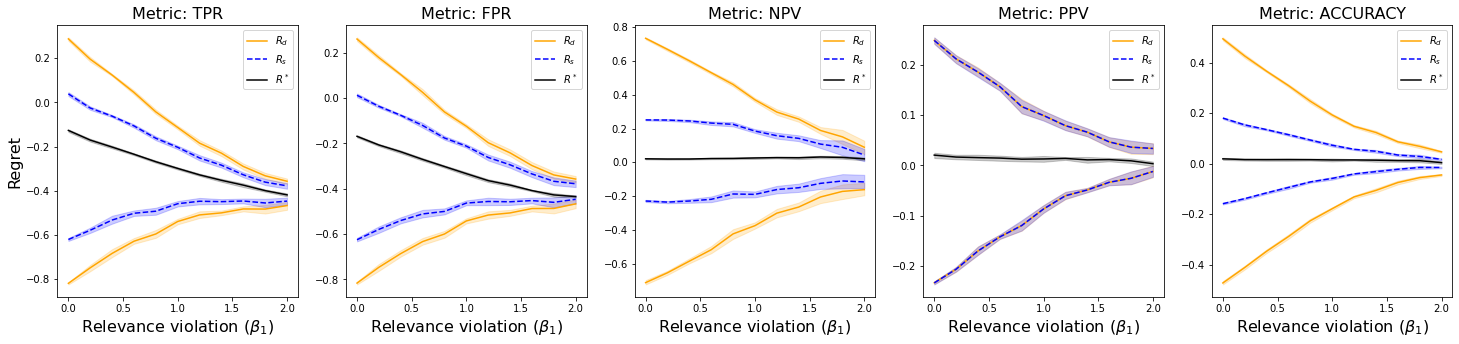

In [7]:
lambdas = np.arange(1, 2.6, .1)
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

iv_dgp = set_dgp_config(dgp, 'IV')
beta_zd = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
brdf = experiments.relevance_sensitivity_experiment(iv_dgp, beta_zd, n_sims=10)
plots.plot_relevance_sensitivity(brdf)


outcome regression error: 0.0896636157362187
propensitiy error: 0.08086972300807793
outcome regression error: 0.09233565495725934
propensitiy error: 0.08059456474804813
outcome regression error: 0.0901062203560358
propensitiy error: 0.07959630702281598
outcome regression error: 0.0892912223665846
propensitiy error: 0.08038190479600173
outcome regression error: 0.08754630461844999
propensitiy error: 0.07861238269269295
outcome regression error: 0.09053844439969481
propensitiy error: 0.08140178846569615
outcome regression error: 0.09184291170734389
propensitiy error: 0.07992350956635494
outcome regression error: 0.09081179264174775
propensitiy error: 0.0794931371978932
outcome regression error: 0.09227989732322261
propensitiy error: 0.07837456987744079
outcome regression error: 0.08904990076571406
propensitiy error: 0.07842671631114725
outcome regression error: 0.08830078574490997
propensitiy error: 0.07874504184174509
outcome regression error: 0.0880222504993466
propensitiy error: 0.082

outcome regression error: 0.09266605631273649
propensitiy error: 0.082757693548339
outcome regression error: 0.09086634828789827
propensitiy error: 0.08235420135555413
outcome regression error: 0.08693092260019906
propensitiy error: 0.07265606786575673
outcome regression error: 0.08959802127378137
propensitiy error: 0.07982950580415979
outcome regression error: 0.08957022440196136
propensitiy error: 0.07807088162224994
outcome regression error: 0.09269124015302256
propensitiy error: 0.07710989190909648
outcome regression error: 0.0930849717349746
propensitiy error: 0.081679741227709
outcome regression error: 0.09034576911416767
propensitiy error: 0.07800819432131942
outcome regression error: 0.09268918540895764
propensitiy error: 0.07720067599584644
outcome regression error: 0.09338375356392292
propensitiy error: 0.07831914811940899
outcome regression error: 0.08950831928347312
propensitiy error: 0.07775270267170334
outcome regression error: 0.09023623318104544
propensitiy error: 0.080

outcome regression error: 0.09124060920840305
propensitiy error: 0.07285013035250713
outcome regression error: 0.08871215663288684
propensitiy error: 0.072651132333459
outcome regression error: 0.088608556882191
propensitiy error: 0.07128384149580555
outcome regression error: 0.0910386883277808
propensitiy error: 0.07322136254659278
outcome regression error: 0.09361047915402938
propensitiy error: 0.0739016532565827
outcome regression error: 0.08864094269551695
propensitiy error: 0.07143541599074524
outcome regression error: 0.09100911813402951
propensitiy error: 0.0748466217916488
outcome regression error: 0.08936523641584071
propensitiy error: 0.07398573960231015
outcome regression error: 0.09113329784889658
propensitiy error: 0.07363625908885535
outcome regression error: 0.09159552687211756
propensitiy error: 0.07326889694201655
outcome regression error: 0.09123441723892267
propensitiy error: 0.0731208247141006
outcome regression error: 0.0887799834267382
propensitiy error: 0.0729398

outcome regression error: 0.08651411101589379
propensitiy error: 0.06683455630803106
outcome regression error: 0.08760944504189336
propensitiy error: 0.06779952174498063
outcome regression error: 0.0865255516646665
propensitiy error: 0.0616518079126695
outcome regression error: 0.08471595237790051
propensitiy error: 0.06273573589971113
outcome regression error: 0.08596388290835648
propensitiy error: 0.0632197860193022
outcome regression error: 0.08672315601372653
propensitiy error: 0.06109663653047833
outcome regression error: 0.08738510214544594
propensitiy error: 0.06239820702576691
outcome regression error: 0.08725297621262056
propensitiy error: 0.06422708942159233
outcome regression error: 0.0911352752769927
propensitiy error: 0.06468077565275351
outcome regression error: 0.08815652264078386
propensitiy error: 0.062607445571314
outcome regression error: 0.08767181629556957
propensitiy error: 0.06184079010269203
outcome regression error: 0.09023371765018891
propensitiy error: 0.0646

outcome regression error: 0.08809885795420254
propensitiy error: 0.058515120982958836
outcome regression error: 0.08974942457748082
propensitiy error: 0.06118500066164653
outcome regression error: 0.0877668194639513
propensitiy error: 0.06006409195190386
outcome regression error: 0.08769103412772716
propensitiy error: 0.05484462887007409
outcome regression error: 0.0895799138570778
propensitiy error: 0.05389115819194531
outcome regression error: 0.08863317206271128
propensitiy error: 0.055465394322930545
outcome regression error: 0.09066464154565108
propensitiy error: 0.055637971338174524
outcome regression error: 0.08642703710528118
propensitiy error: 0.05563353374749052
outcome regression error: 0.08904653008338219
propensitiy error: 0.056629056162456094
outcome regression error: 0.08987162346628162
propensitiy error: 0.05627849045332856
outcome regression error: 0.0878038490117416
propensitiy error: 0.057139673416599576
outcome regression error: 0.09225903930557888
propensitiy error

outcome regression error: 0.08769589068966056
propensitiy error: 0.05065423331475959
outcome regression error: 0.09042562454267924
propensitiy error: 0.051136688752303774
outcome regression error: 0.09059353516265894
propensitiy error: 0.049868932422580656
outcome regression error: 0.0889647968066343
propensitiy error: 0.048302609758285084
outcome regression error: 0.08968634460259414
propensitiy error: 0.0485911360827092
outcome regression error: 0.08942155362918074
propensitiy error: 0.04857806267659487
outcome regression error: 0.08717205335989762
propensitiy error: 0.049086994009295684
outcome regression error: 0.08769680173153219
propensitiy error: 0.0488284013006308
outcome regression error: 0.09397583694755393
propensitiy error: 0.04992956790945253
outcome regression error: 0.08907150076079241
propensitiy error: 0.04893961860976236
outcome regression error: 0.09059842363205124
propensitiy error: 0.048371850490718495
outcome regression error: 0.09305737762976386
propensitiy error

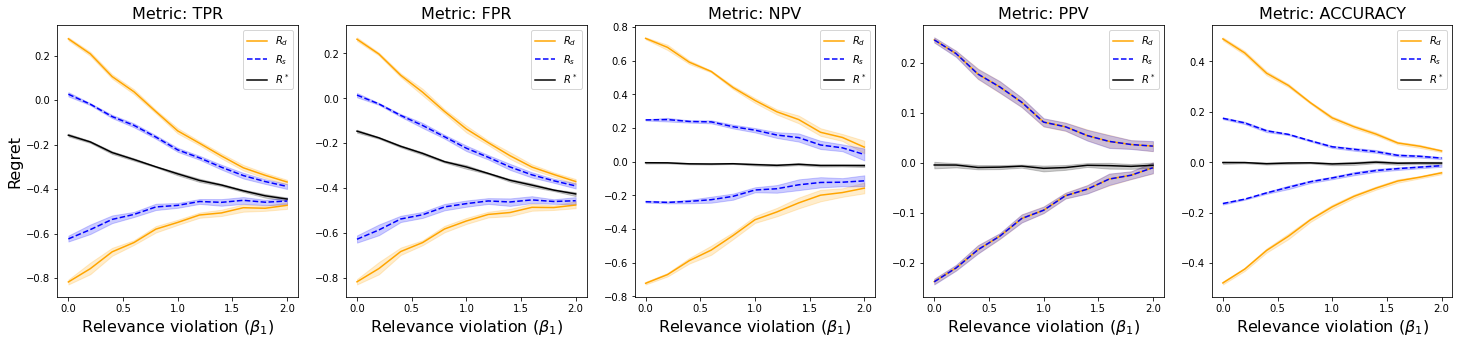

In [7]:
relevance_bounds = []

for zd in beta_zd:
    iv_dgp['beta_zd'] = zd
    
    for sim in range(Nsims):
        
        data = generate_data(iv_dgp)
        
        bounds = estimation.estimate_bounds(iv_dgp, data, id_method='IV', est_method='plugin', K=5)
        bounds['beta_zy'] = zd
        relevance_bounds.append(bounds)

brdf = pd.concat(relevance_bounds)

metric_dict = {
    'm_y=1': 'TPR',
    'm_y=0': 'FPR',
    'm_a=0': 'NPV',
    'm_a=1': 'PPV',
    'm_u': 'ACCURACY',
}

metrics = brdf['metric'].unique().tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Adjust the figsize as needed

for i, metric in enumerate(metrics):
    
    # Filter the DataFrame for the current metric
    metric_df = brdf[brdf['metric'] == metric]
    
    # Reset the index to avoid the duplicate labels error
    metric_df = metric_df.reset_index(drop=True)
    
    # Create each lineplot on the corresponding subplot axis
    sns.lineplot(ax=axes[i], data=metric_df, x='beta_zy', y='Rs_up', color='orange', linestyle='-', label='$R_d$')
    sns.lineplot(ax=axes[i], data=metric_df, x='beta_zy', y='Rs_down', color='orange', linestyle='-')
    sns.lineplot(ax=axes[i], data=metric_df, x='beta_zy', y='Rd_up', color='blue', linestyle='--', label='$R_s$')
    sns.lineplot(ax=axes[i], data=metric_df, x='beta_zy', y='Rd_down', color='blue', linestyle='--')
    sns.lineplot(ax=axes[i], data=metric_df, x='beta_zy', y='R_oracle', color='black', label='$R^*$')

    # Set the titles, labels, etc.
    axes[i].set_xlabel(r'Relevance violation ($\beta_1$)', fontsize=16)
    axes[i].set_title(f'Metric: {metric_dict[metric]}', fontsize=16)
    axes[i].set_ylabel(f'', fontsize=16)
    
axes[0].set_ylabel(f'Regret', fontsize=16)
axes[0].legend()


## Robustness check: relevance condition

In [8]:

lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)
Nsims = 10

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.5,
    'id_assumption': 'MSM'
}

msm_dgp = set_dgp_config(dgp, 'MSM')
lambda_star = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.3]

msm_bounds = []

for ls in lambda_star:
    
    msm_dgp['lambda_star'] = ls
    
    for sim in range(Nsims):
        
        data = generate_data(msm_dgp)
        bounds = estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='oracle', K=5)
        bounds['ls'] = ls
        msm_bounds.append(bounds)

msmdf = pd.concat(msm_bounds)


oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 0, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.1

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 0.2, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 0.6, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 0.8, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 1.2, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 1.6, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 1.8, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0.12299755]), 'lambda': 1.5, 'lambda_star': 2.2, 'id_assumption': 'MSM', 'beta_zd': 0}
oracle dgp {'N': 10000, 'Dx': 5, 'Du': 2, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51593613,  1.78279847, -0.14649117,  0.61584486, -0.62154169,
        0.8568778 ,  1.94975042]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([1.60953581, 0.87819664, 1.51523463, 2.03785104, 1.97453219,
       0.59409334, 2.65165207]), 'mu0_coeffs': array([-1.80755729,  0.6185085 ,  0.04847145, -0.83244667, -0.35218985,
        1.452996  , -0

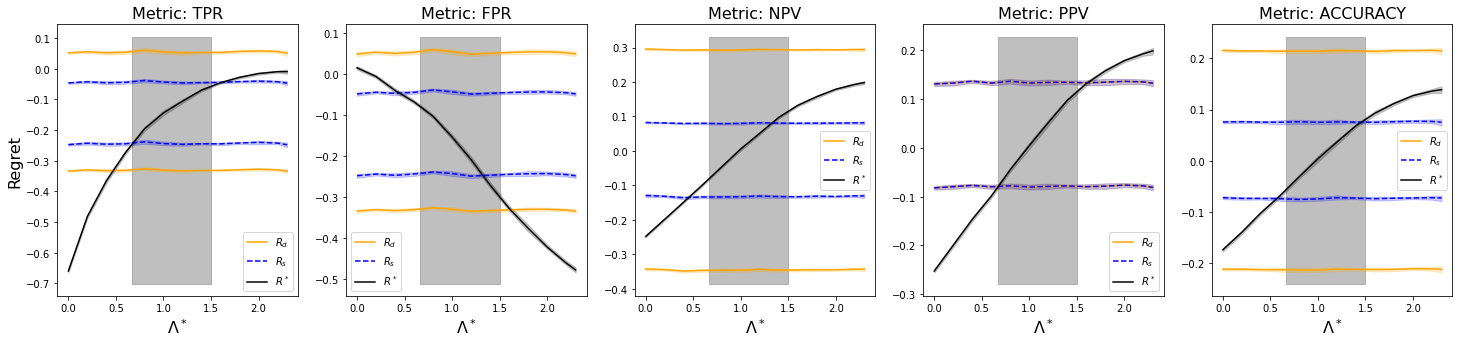

In [53]:


lam = msm_dgp['lambda']
metric_dict = {
    'm_y=1': 'TPR',
    'm_y=0': 'FPR',
    'm_a=0': 'NPV',
    'm_a=1': 'PPV',
    'm_u': 'ACCURACY',
}

metrics = msmdf['metric'].unique().tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Adjust the figsize as needed


for i, metric in enumerate(metrics):
    

    # Filter the DataFrame for the current metric
    metric_df = msmdf[msmdf['metric'] == metric]
    
    # Reset the index to avoid the duplicate labels error
    metric_df = metric_df.reset_index(drop=True)
    ymin = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].min().min()
    ymax = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].max().max()
    
    # Create each lineplot on the corresponding subplot axis
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_up', color='orange', linestyle='-', label='$R_d$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_down', color='orange', linestyle='-')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_up', color='blue', linestyle='--', label='$R_s$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_down', color='blue', linestyle='--')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='R_oracle', color='black', label='$R^*$')

    # Set the titles, labels, etc.
    axes[i].set_xlabel(r'$\Lambda^*$', fontsize=16)
    axes[i].set_title(f'Metric: {metric_dict[metric]}', fontsize=16)
    axes[i].set_ylabel(f'', fontsize=16)
    
    ymin, ymax = axes[i].get_ylim()
    axes[i].fill_between([lam**-1, lam], ymin, ymax, color='grey', alpha=0.5, zorder=-1)
    
    
    # Get the current y-limits of the subplot
   

    


    
axes[0].set_ylabel(f'Regret', fontsize=16)
axes[0].legend()